## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

![mesh](data/mesh.png)

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(10)
reduced_problem = reduction_method.offline()

=                ThermalBlock POD-Galerkin offline phase begins                =

###################################### 0 #######################################
truth solve for mu = (5.533253688880515, 0.43037873274483895)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (6.067357423109274, 0.08976636599379373)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (4.294182513455157, 0.29178822613331223)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (4.432113391500656, 0.7835460015641595)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (9.64026132896019, -0.2331169623484446)
update snapshots matrix

###################################### 5 #######################################

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

0 	Loss(training) = 2.90490869213975 	Loss(validation) = 2.1297817872428677
100 	Loss(training) = 0.06384157368176573 	Loss(validation) = 0.05864248306020352
200 	Loss(training) = 0.04967235564504062 	Loss(validation) = 0.04761812902301256
300 	Loss(training) = 0.03888633314575952 	Loss(validation) = 0.035487637780984085
400 	Loss(training) = 0.029436622522761115 	Loss(validation) = 0.024114995697997486
500 	Loss(training) = 0.02287664167172575 	Loss(validation) = 0.017059940690708236
600 	Loss(training) = 0.019075803411729243 	Loss(validation) = 0.013443660721695888
700 	Loss(training) = 0.016613073619283825 	Loss(validation) = 0.01112429554720849
800 	Loss(training) = 0.01471083841626324 	Loss(validation) = 0.009467465821553939
900 	Loss(training) = 0.013102558623071695 	Loss(validation) = 0.008197297475626869
1000 	Loss(training) = 0.011715465113819473 	Loss(validation) = 0.007119983447162965
1100 	Loss(training) = 0.010520373582096084 	Loss(validation) = 0.0061186120179920495
1200 

9500 	Loss(training) = 6.387937419232302e-05 	Loss(validation) = 0.00010460608929622373
9600 	Loss(training) = 6.191366342707635e-05 	Loss(validation) = 7.549884630499645e-05
9700 	Loss(training) = 6.004153204636328e-05 	Loss(validation) = 7.280785898928135e-05
9800 	Loss(training) = 6.567148710662454e-05 	Loss(validation) = 7.85848003468411e-05
9900 	Loss(training) = 5.6561935671043916e-05 	Loss(validation) = 6.731664817227604e-05


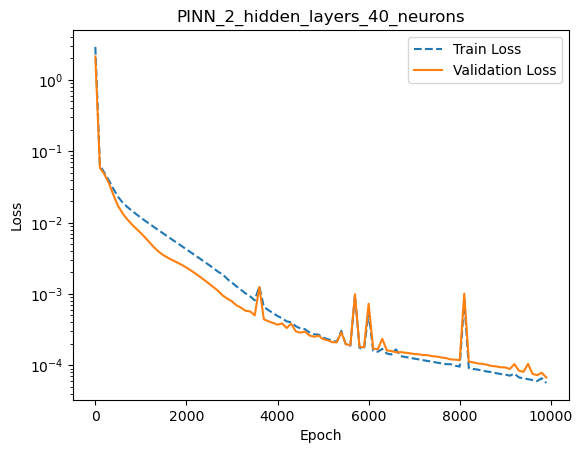

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=3000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

0 	Loss(training) = 1.1349815523209728 	Loss(validation) = 0.08078285694594288
100 	Loss(training) = 0.3706193286776466 	Loss(validation) = 0.09409607464970561
200 	Loss(training) = 0.04413781786308796 	Loss(validation) = 0.10630759858195697
300 	Loss(training) = 0.0028741585115425 	Loss(validation) = 0.03615075683639954
400 	Loss(training) = 0.0007100416279450519 	Loss(validation) = 0.026274195858268807
500 	Loss(training) = 0.00032215993169575817 	Loss(validation) = 0.02317412514803758
600 	Loss(training) = 0.00018496742632288947 	Loss(validation) = 0.021451554867207463
700 	Loss(training) = 0.00011639991158212453 	Loss(validation) = 0.02018548345721253
800 	Loss(training) = 7.571548269638682e-05 	Loss(validation) = 0.019197122319600593
900 	Loss(training) = 4.9096463132697075e-05 	Loss(validation) = 0.018415633463831314
1000 	Loss(training) = 3.1101117491682154e-05 	Loss(validation) = 0.017795446077414945
1100 	Loss(training) = 1.905161112857087e-05 	Loss(validation) = 0.01730490235

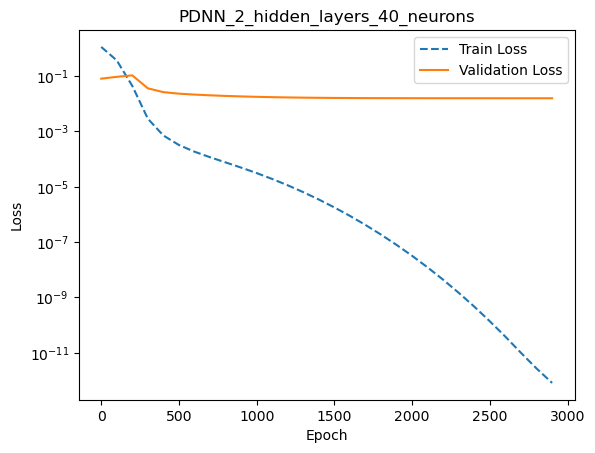

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

0 	Loss(training) = 3.8531933101357936 	Loss(validation) = 3.0191409624097783
100 	Loss(training) = 0.7557248796710476 	Loss(validation) = 0.1316253627163675
200 	Loss(training) = 0.5012687268376558 	Loss(validation) = 0.10771110867292225
300 	Loss(training) = 0.25177364003363883 	Loss(validation) = 0.06617155951951217
400 	Loss(training) = 0.08215320700239057 	Loss(validation) = 0.05140360401891841
500 	Loss(training) = 0.0387848268145224 	Loss(validation) = 0.043144789583940565
600 	Loss(training) = 0.023276115547610665 	Loss(validation) = 0.03647954089802482
700 	Loss(training) = 0.016203335243249826 	Loss(validation) = 0.03097784395783254
800 	Loss(training) = 0.012085205539831338 	Loss(validation) = 0.026797334563374183
900 	Loss(training) = 0.00937081734526205 	Loss(validation) = 0.024003393660631006
1000 	Loss(training) = 0.007487745070488633 	Loss(validation) = 0.02223848716117027
1100 	Loss(training) = 0.006154026525998779 	Loss(validation) = 0.021096843257493572
1200 	Loss(tr

9700 	Loss(training) = 6.406921454977867e-05 	Loss(validation) = 0.01338243796066194
9800 	Loss(training) = 5.851479667272113e-05 	Loss(validation) = 0.013267698372735899
9900 	Loss(training) = 5.734917655168917e-05 	Loss(validation) = 0.01323539220123827
10000 	Loss(training) = 5.958198010486598e-05 	Loss(validation) = 0.013260157648688566
10100 	Loss(training) = 5.5269277745724005e-05 	Loss(validation) = 0.01318086541104613
10200 	Loss(training) = 5.4239611493625884e-05 	Loss(validation) = 0.013152454006821567
10300 	Loss(training) = 5.338573666850213e-05 	Loss(validation) = 0.013126185611926024
10400 	Loss(training) = 5.239491310390421e-05 	Loss(validation) = 0.013093905247610385
10500 	Loss(training) = 5.159796815583801e-05 	Loss(validation) = 0.013083852231373974
10600 	Loss(training) = 5.0780315602459285e-05 	Loss(validation) = 0.013045354847203702
10700 	Loss(training) = 4.9821341121727026e-05 	Loss(validation) = 0.013007538914366743
10800 	Loss(training) = 5.023385603010511e-05

19200 	Loss(training) = 2.6351467847465805e-05 	Loss(validation) = 0.01194360754350546
19300 	Loss(training) = 2.6079992978972467e-05 	Loss(validation) = 0.011938624019954701
19400 	Loss(training) = 2.5949601065967084e-05 	Loss(validation) = 0.011925149258428202
19500 	Loss(training) = 0.00024746987273858024 	Loss(validation) = 0.012606551761304607
19600 	Loss(training) = 2.5755419687647594e-05 	Loss(validation) = 0.011918240309928342
19700 	Loss(training) = 2.5617713223986488e-05 	Loss(validation) = 0.011908470068336736
19800 	Loss(training) = 0.0007736006162218592 	Loss(validation) = 0.011849976481690542
19900 	Loss(training) = 2.5434150740790412e-05 	Loss(validation) = 0.0119055341893481
20000 	Loss(training) = 2.52819597534952e-05 	Loss(validation) = 0.011887577712790144
20100 	Loss(training) = 3.0150798558325363e-05 	Loss(validation) = 0.011918688788730633
20200 	Loss(training) = 2.508594051552287e-05 	Loss(validation) = 0.011883631373800873
20300 	Loss(training) = 2.4959835599161

28600 	Loss(training) = 7.069796106865125e-05 	Loss(validation) = 0.011194341448737506
28700 	Loss(training) = 1.8112680885315037e-05 	Loss(validation) = 0.011522131499671224
28800 	Loss(training) = 1.8041486251429908e-05 	Loss(validation) = 0.011512931178968549
28900 	Loss(training) = 1.811913145146615e-05 	Loss(validation) = 0.011496893365860789
29000 	Loss(training) = 1.791936829335131e-05 	Loss(validation) = 0.011513841464958789
29100 	Loss(training) = 7.855098063890344e-05 	Loss(validation) = 0.011899660245131304
29200 	Loss(training) = 1.7803184226217573e-05 	Loss(validation) = 0.011513071896637903
29300 	Loss(training) = 1.772767564737257e-05 	Loss(validation) = 0.011502518358148807
29400 	Loss(training) = 1.7939984889898402e-05 	Loss(validation) = 0.011513340682071962
29500 	Loss(training) = 1.7613638260514244e-05 	Loss(validation) = 0.011498514915942398
29600 	Loss(training) = 0.00028085804448795996 	Loss(validation) = 0.011214487374698604
29700 	Loss(training) = 1.75119045990

38000 	Loss(training) = 0.00038337831304912897 	Loss(validation) = 0.012256304150914865
38100 	Loss(training) = 1.335892898731804e-05 	Loss(validation) = 0.0113933643042127
38200 	Loss(training) = 1.3310365697375952e-05 	Loss(validation) = 0.011383086632912135
38300 	Loss(training) = 1.5009303815972514e-05 	Loss(validation) = 0.011453378697906053
38400 	Loss(training) = 1.3240026962465994e-05 	Loss(validation) = 0.01139644033322415
38500 	Loss(training) = 1.3530193653274019e-05 	Loss(validation) = 0.01136095863436207
38600 	Loss(training) = 1.5597334941009867e-05 	Loss(validation) = 0.011590131444085812
38700 	Loss(training) = 1.3115897255430227e-05 	Loss(validation) = 0.011389503875863044
38800 	Loss(training) = 1.3995178771837066e-05 	Loss(validation) = 0.01142286346497549
38900 	Loss(training) = 1.3041621544910349e-05 	Loss(validation) = 0.01139277999604657
39000 	Loss(training) = 3.251826487632515e-05 	Loss(validation) = 0.011142216579047163
39100 	Loss(training) = 1.29687383348068

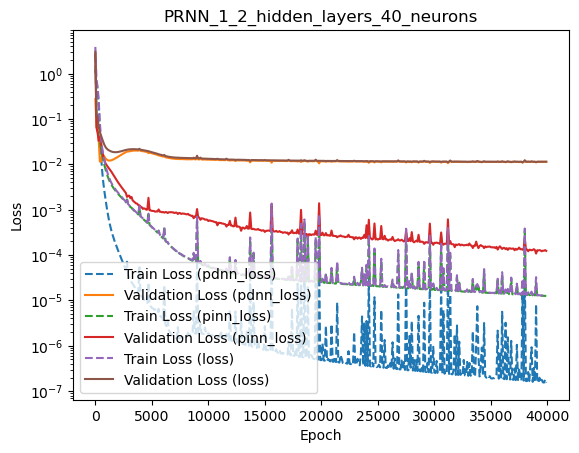

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

# test_set_mu = data.train_data_no_snaps
# online_mu = tuple(np.array(data.train_data_no_snaps[0,:]))

#### 4.6.2 PINN Error Analysis

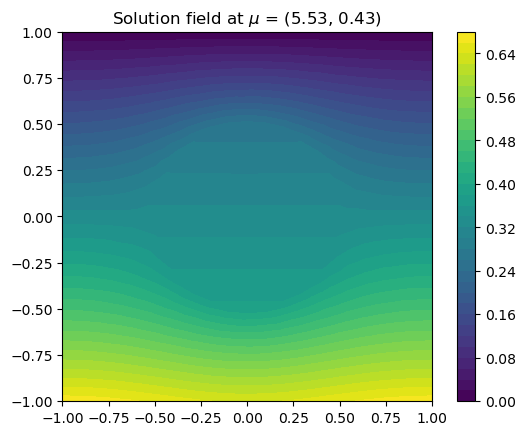

In [18]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn
)

################################## PINN N = 4 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00017983454562276843	0.0001798358198576145	4.5963247434574336e-07
mean	0.008503791551674767	0.008503792122975083	6.332196261618342e-07
max	0.09964434147227574	0.09964435728999893	1.660229789911146e-06


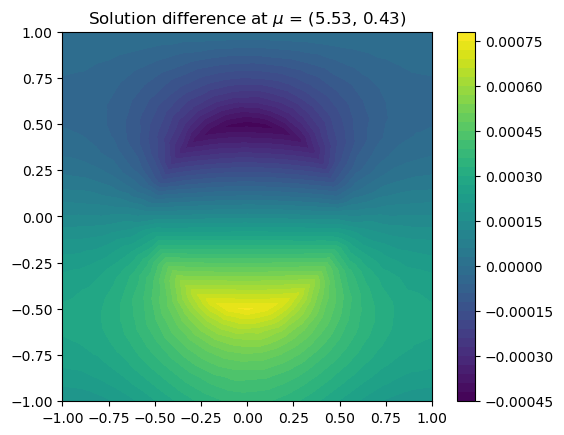

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)


#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################## PDNN N = 4 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	4.7113617642546356e-07	8.116108651954554e-08	4.5963247434574336e-07
mean	0.4821815469277674	0.48218152284290333	6.332196261618342e-07
max	9.661851642865663	9.66185172344153	1.660229789911146e-06


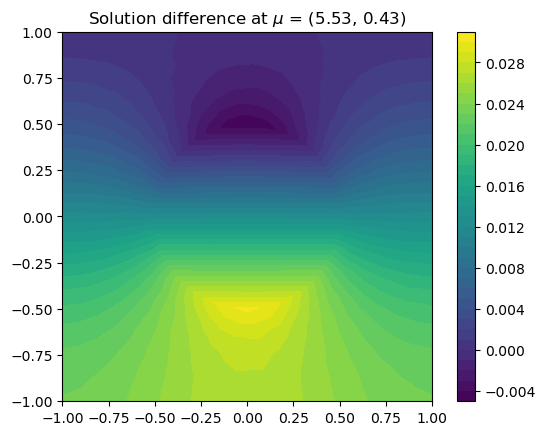

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

################################# PRNN_1 N = 4 #################################
ERROR	NN-HF			NN-RO			RO-HF
min	4.7190163809220346e-05	4.7204295768797675e-05	4.5963247434574336e-07
mean	0.0069160465710289285	0.006916046372809773	6.332196261618342e-07
max	0.2340347856400865	0.23403478717087234	1.660229789911146e-06


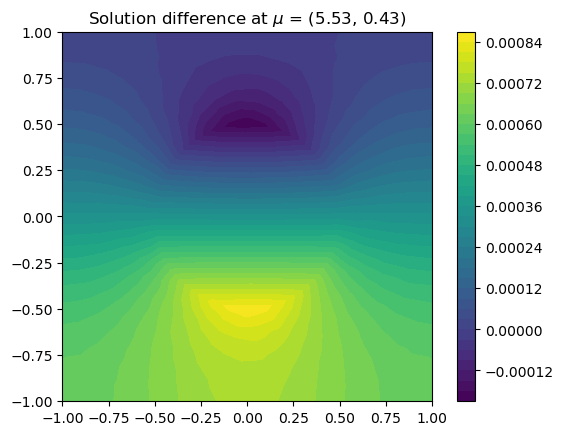

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 4 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.008503791551674767	0.008503792122975083	6.332196261618342e-07
pdnn_net	0.4821815469277674	0.48218152284290333	6.332196261618342e-07
prnn_net	0.0069160465710289285	0.006916046372809773	6.332196261618342e-07
#####################################################################################


### 4.7. Perform a speedup analysis

In [26]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()
reduction_method.speedup_analysis()

=               ThermalBlock POD-Galerkin error analysis begins                =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 98 ######################################
###################################### 99 ######################################

N	gmean(error_u)        	max(error_u)          	gmean(relative_error_u)	max(relative_error_u)
1	0.23087818913178434   	0.9165671801916867    	0.3080495986145912     	0.5886264603528667   
2	0.001330196956798983  	0.007396195190820473  	0.0017748174488079699  	0.004861753371120837 
3	1.9729488939517383e-05	0.00013158387295099201	2.6324102642802014e-05 	8.742043876348174e-05
4	1.6818842759004676e-07	2.1872293945387317e-06	2.2440568251841187e-07 	1.296445450472622e-06

N	gmean(error_output)  	max(error_output)     	gmean(relative_error_output)	max(relative_error_output)
1	0.05330473821679727  	0.8400953958045572    	0.09489455520665666         	0.3464811098275529        
2	1.769424336733848e-06	5.4703703339598064e-05	3.1499776759672912e-06      	2.3636645852750626e-05    
3	3.898059033353984e-10	1.7314354394670772e-08	6.93943147

###################################### 81 ######################################
###################################### 82 ######################################
###################################### 83 ######################################
###################################### 84 ######################################
###################################### 85 ######################################
###################################### 86 ######################################
###################################### 87 ######################################
###################################### 88 ######################################
###################################### 89 ######################################
###################################### 90 ######################################
###################################### 91 ######################################
###################################### 92 ######################################
############################